In [11]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics

import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import os
import time
import datetime


import matplotlib.pyplot as plt
from tqdm import tqdm_notebook


from itertools import product
from functools import partial



In [2]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, importance_features = False,model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
    if importance_features:        
        results, bad_features = permutation_importance(model=model, X_val=X_train, y_val=y_train, metric=metric, verbose=False)
        result_dict['Bad features'] = bad_features
    
    return result_dict

def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def permutation_importance(model, X_val, y_val, metric, threshold=0.005,
                           minimize=True, verbose=True):
    results = {}
    
    y_pred = model.predict(X_val)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')

    
    for col in tqdm(X_val.columns):
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        preds = model.predict(X_val)
        results[col] = metric(y_val, preds)

        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] + threshold]
    bad_features.remove('base_score')
    
    return results, bad_features


In [3]:
def map_atom_info(df_1, df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    return df

def AddGiba(df, n):    #Function from https://www.kaggle.com/artgor/molecular-properties-eda-and-models

    if n == 0: #test
        rows_to_exclude = np.where(index_type_test==False)[0]+1
        giba = pd.read_csv('External data/test_giba.csv.gz', compression='gzip', sep=',', quotechar='"',
                       header=0, skiprows=rows_to_exclude, usecols=giba_columns)
    
    else: #train
        rows_to_exclude = np.where(index_type==False)[0]+1 # retain the header row
        giba = pd.read_csv('External data/train_giba.csv.gz', compression='gzip', sep=',', quotechar='"',
                       header=0, skiprows=rows_to_exclude, usecols=giba_columns)
#     return pd.merge(df, giba, how = 'left',
#               left_on  = ['molecule_name', f'atom_index_0'],
#               right_on = ['molecule_name',  'atom_index_0'])
    return pd.concat((df, giba), axis=1)
    

def AddExternalData(df, atom_idx):    #Function from https://www.kaggle.com/artgor/molecular-properties-eda-and-models
    structures = pd.read_csv(f'{file_folder}/structures.csv')
    yukawa = pd.read_csv('External data/structures_yukawa.csv')
    structures = pd.concat([structures, yukawa], axis=1)

    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    if atom_idx == 1:

        potential_energy = pd.read_pickle('External data/potential_energy_upd.pkl')
        df = pd.merge(df, potential_energy, how = 'left',
                     left_on = 'molecule_name',
                      right_on ='molecule_name')
        bonds = pd.read_csv('External data/bonds.csv')

        df = pd.merge(df, bonds, how='left',
            left_on=['molecule_name', 'atom_index_1'],
            right_on= ['molecule_name', 'atom_index']).drop('atom_index', axis = 1)
    return df

def AddDistData(df, n, t):
#     t = train.type.unique()[t]
    if n == 1: #Train
        dist = pd.read_csv(f'External data/dist/{t}.csv')
        return pd.merge(df, dist.drop(columns = ['Unnamed: 0','molecule_index','atom_index_0',
                                                 'atom_index_1','scalar_coupling_constant'], axis = 1),
                        left_on='id', right_on='id')
    else: #Test
        dist = pd.read_csv(f'External data/dist/test_{t}.csv')
        return pd.merge(df, dist.drop(columns = ['Unnamed: 0','molecule_index','atom_index_0',
                                                 'atom_index_1'], axis = 1),
                        left_on='id', right_on='id')

def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, 
                                    prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
    return df

def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['dist']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df


def find_closest_atom(df):    
    df_temp = df.loc[:,["molecule_name",
                      "atom_index_0","atom_index_1",
                      "dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_ = df_temp.copy()
    df_temp_ = df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all = pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('max')
    
    df_temp = df_temp_all[df_temp_all["min_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp = df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'dist': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'dist': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df

def add_cos_features(df): #https://www.kaggle.com/kmat2019/effective-feature
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



def create_features(df):
    #ID features
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    #Structure features
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    #Distance features
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')    
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    
    #Potential energy features
    df['molecule_pot_mean'] = df.groupby('molecule_name')['potential_energy'].transform('mean')
    df['molecule_pot_min'] = df.groupby('molecule_name')['potential_energy'].transform('min')
    df['molecule_pot_max'] = df.groupby('molecule_name')['potential_energy'].transform('max')    
    df[f'molecule_atom_index_0_pot_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['potential_energy'].transform('mean')
#     df[f'molecule_atom_index_0_pot_mean_diff'] = df[f'molecule_atom_index_0_pot_mean'] - df['potential_energy']
#     df[f'molecule_atom_index_0_pot_mean_div'] = df[f'molecule_atom_index_0_pot_mean'] / df['potential_energy']
    df[f'molecule_atom_index_0_pot_max'] = df.groupby(['molecule_name', 'atom_index_0'])['potential_energy'].transform('max')
#     df[f'molecule_atom_index_0_pot_max_diff'] = df[f'molecule_atom_index_0_pot_max'] - df['potential_energy']
#     df[f'molecule_atom_index_0_pot_max_div'] = df[f'molecule_atom_index_0_pot_max'] / df['potential_energy']
    df[f'molecule_atom_index_0_pot_min'] = df.groupby(['molecule_name', 'atom_index_0'])['potential_energy'].transform('min')
#     df[f'molecule_atom_index_0_pot_min_diff'] = df[f'molecule_atom_index_0_pot_min'] - df['potential_energy']
#     df[f'molecule_atom_index_0_pot_min_div'] = df[f'molecule_atom_index_0_pot_min'] / df['potential_energy']
    df[f'molecule_atom_index_0_pot_std'] = df.groupby(['molecule_name', 'atom_index_0'])['potential_energy'].transform('std')
    df[f'molecule_atom_index_0_pot_std_diff'] = df[f'molecule_atom_index_0_pot_std'] - df['potential_energy']
#     df[f'molecule_atom_index_0_pot_std_div'] = df[f'molecule_atom_index_0_pot_std'] / df['potential_energy']
    df[f'molecule_atom_index_1_pot_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['potential_energy'].transform('mean')
    df[f'molecule_atom_index_1_pot_mean_diff'] = df[f'molecule_atom_index_1_pot_mean'] - df['potential_energy']
#     df[f'molecule_atom_index_1_pot_mean_div'] = df[f'molecule_atom_index_1_pot_mean'] / df['potential_energy']
    df[f'molecule_atom_index_1_pot_max'] = df.groupby(['molecule_name', 'atom_index_1'])['potential_energy'].transform('max')
#     df[f'molecule_atom_index_1_pot_max_diff'] = df[f'molecule_atom_index_1_pot_max'] - df['potential_energy']
#     df[f'molecule_atom_index_1_pot_max_div'] = df[f'molecule_atom_index_1_pot_max'] / df['potential_energy']
    df[f'molecule_atom_index_1_pot_min'] = df.groupby(['molecule_name', 'atom_index_1'])['potential_energy'].transform('min')
#     df[f'molecule_atom_index_1_pot_min_diff'] = df[f'molecule_atom_index_1_pot_min'] - df['potential_energy']
#     df[f'molecule_atom_index_1_pot_min_div'] = df[f'molecule_atom_index_1_pot_min'] / df['potential_energy']
    df[f'molecule_atom_index_1_pot_std'] = df.groupby(['molecule_name', 'atom_index_1'])['potential_energy'].transform('std')
    df[f'molecule_atom_index_1_pot_std_diff'] = df[f'molecule_atom_index_1_pot_std'] - df['potential_energy']
#     df[f'molecule_atom_index_1_pot_std_div'] = df[f'molecule_atom_index_1_pot_std'] / df['potential_energy']
    df[f'molecule_atom_1_pot_mean'] = df.groupby(['molecule_name', 'atom_1'])['potential_energy'].transform('mean')
    df[f'molecule_atom_1_pot_min'] = df.groupby(['molecule_name', 'atom_1'])['potential_energy'].transform('min')
#     df[f'molecule_atom_1_pot_min_diff'] = df[f'molecule_atom_1_pot_min'] - df['potential_energy']
#     df[f'molecule_atom_1_pot_min_div'] = df[f'molecule_atom_1_pot_min'] / df['potential_energy']
    df[f'molecule_atom_1_pot_std'] = df.groupby(['molecule_name', 'atom_1'])['potential_energy'].transform('std')
    df[f'molecule_atom_1_pot_std_diff'] = df[f'molecule_atom_1_pot_std'] - df['potential_energy']
    df[f'molecule_type_0_pot_std'] = df.groupby(['molecule_name', 'type'])['potential_energy'].transform('std')
    df[f'molecule_type_0_pot_std_diff'] = df[f'molecule_type_0_pot_std'] - df['potential_energy']
    df[f'molecule_type_pot_mean'] = df.groupby(['molecule_name', 'type'])['potential_energy'].transform('mean')
#     df[f'molecule_type_pot_mean_diff'] = df[f'molecule_type_pot_mean'] - df['potential_energy']
#     df[f'molecule_type_pot_mean_div'] = df[f'molecule_type_pot_mean'] / df['potential_energy']
    df[f'molecule_type_pot_max'] = df.groupby(['molecule_name', 'type'])['potential_energy'].transform('max')
    df[f'molecule_type_pot_min'] = df.groupby(['molecule_name', 'type'])['potential_energy'].transform('min')
    df[f'molecule_type_pot_std'] = df.groupby(['molecule_name', 'type'])['potential_energy'].transform('std')
    df[f'molecule_type_pot_std_diff'] = df[f'molecule_type_pot_std'] - df['potential_energy']
    
    #Mulliken_charge stats
    df['molecule_mul_mean'] = df.groupby('molecule_name')['mulliken_charge'].transform('mean')
    df['molecule_mul_min'] = df.groupby('molecule_name')['mulliken_charge'].transform('min')
    df['molecule_mul_max'] = df.groupby('molecule_name')['mulliken_charge'].transform('max')    
    df[f'molecule_atom_index_0_mul_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['mulliken_charge'].transform('mean')
    df[f'molecule_atom_index_0_mul_mean_diff'] = df[f'molecule_atom_index_0_mul_mean'] - df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_mean_div'] = df[f'molecule_atom_index_0_mul_mean'] / df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_max'] = df.groupby(['molecule_name', 'atom_index_0'])['mulliken_charge'].transform('max')
    df[f'molecule_atom_index_0_mul_max_diff'] = df[f'molecule_atom_index_0_mul_max'] - df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_max_div'] = df[f'molecule_atom_index_0_mul_max'] / df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_min'] = df.groupby(['molecule_name', 'atom_index_0'])['mulliken_charge'].transform('min')
    df[f'molecule_atom_index_0_mul_min_diff'] = df[f'molecule_atom_index_0_mul_min'] - df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_min_div'] = df[f'molecule_atom_index_0_mul_min'] / df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_std'] = df.groupby(['molecule_name', 'atom_index_0'])['mulliken_charge'].transform('std')
    df[f'molecule_atom_index_0_mul_std_diff'] = df[f'molecule_atom_index_0_mul_std'] - df['mulliken_charge']
    df[f'molecule_atom_index_0_mul_std_div'] = df[f'molecule_atom_index_0_mul_std'] / df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['mulliken_charge'].transform('mean')
    df[f'molecule_atom_index_1_mul_mean_diff'] = df[f'molecule_atom_index_1_mul_mean'] - df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_mean_div'] = df[f'molecule_atom_index_1_mul_mean'] / df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_max'] = df.groupby(['molecule_name', 'atom_index_1'])['mulliken_charge'].transform('max')
    df[f'molecule_atom_index_1_mul_max_diff'] = df[f'molecule_atom_index_1_mul_max'] - df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_max_div'] = df[f'molecule_atom_index_1_mul_max'] / df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_min'] = df.groupby(['molecule_name', 'atom_index_1'])['mulliken_charge'].transform('min')
    df[f'molecule_atom_index_1_mul_min_diff'] = df[f'molecule_atom_index_1_mul_min'] - df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_min_div'] = df[f'molecule_atom_index_1_mul_min'] / df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_std'] = df.groupby(['molecule_name', 'atom_index_1'])['mulliken_charge'].transform('std')
    df[f'molecule_atom_index_1_mul_std_diff'] = df[f'molecule_atom_index_1_mul_std'] - df['mulliken_charge']
    df[f'molecule_atom_index_1_mul_std_div'] = df[f'molecule_atom_index_1_mul_std'] / df['mulliken_charge']
    df[f'molecule_atom_1_mul_mean'] = df.groupby(['molecule_name', 'atom_1'])['mulliken_charge'].transform('mean')
    df[f'molecule_atom_1_mul_min'] = df.groupby(['molecule_name', 'atom_1'])['mulliken_charge'].transform('min')
    df[f'molecule_atom_1_mul_min_diff'] = df[f'molecule_atom_1_mul_min'] - df['mulliken_charge']
    df[f'molecule_atom_1_mul_min_div'] = df[f'molecule_atom_1_mul_min'] / df['mulliken_charge']
    df[f'molecule_atom_1_mul_std'] = df.groupby(['molecule_name', 'atom_1'])['mulliken_charge'].transform('std')
    df[f'molecule_atom_1_mul_std_diff'] = df[f'molecule_atom_1_mul_std'] - df['mulliken_charge']
    df[f'molecule_type_0_mul_std'] = df.groupby(['molecule_name', 'type'])['mulliken_charge'].transform('std')
    df[f'molecule_type_0_mul_std_diff'] = df[f'molecule_type_0_mul_std'] - df['mulliken_charge']
    df[f'molecule_type_mul_mean'] = df.groupby(['molecule_name', 'type'])['mulliken_charge'].transform('mean')
    df[f'molecule_type_mul_mean_diff'] = df[f'molecule_type_mul_mean'] - df['mulliken_charge']
    df[f'molecule_type_mul_mean_div'] = df[f'molecule_type_mul_mean'] / df['mulliken_charge']
    df[f'molecule_type_mul_max'] = df.groupby(['molecule_name', 'type'])['mulliken_charge'].transform('max')
    df[f'molecule_type_mul_min'] = df.groupby(['molecule_name', 'type'])['mulliken_charge'].transform('min')
    df[f'molecule_type_mul_std'] = df.groupby(['molecule_name', 'type'])['mulliken_charge'].transform('std')
    df[f'molecule_type_mul_std_diff'] = df[f'molecule_type_mul_std'] - df['mulliken_charge']
    
    
    df['molecule_fc_mean'] = df.groupby('molecule_name')['fc'].transform('mean')
    df['molecule_fc_min'] = df.groupby('molecule_name')['fc'].transform('min')
    df['molecule_fc_max'] = df.groupby('molecule_name')['fc'].transform('max')    
    df[f'molecule_atom_index_0_fc_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('mean')
    df[f'molecule_atom_index_0_fc_mean_diff'] = df[f'molecule_atom_index_0_fc_mean'] - df['fc']
    df[f'molecule_atom_index_0_fc_mean_div'] = df[f'molecule_atom_index_0_fc_mean'] / df['fc']
    df[f'molecule_atom_index_0_fc_max'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('max')
    df[f'molecule_atom_index_0_fc_max_diff'] = df[f'molecule_atom_index_0_fc_max'] - df['fc']
    df[f'molecule_atom_index_0_fc_max_div'] = df[f'molecule_atom_index_0_fc_max'] / df['fc']
    df[f'molecule_atom_index_0_fc_min'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('min')
    df[f'molecule_atom_index_0_fc_min_diff'] = df[f'molecule_atom_index_0_fc_min'] - df['fc']
    df[f'molecule_atom_index_0_fc_min_div'] = df[f'molecule_atom_index_0_fc_min'] / df['fc']
    df[f'molecule_atom_index_0_fc_std'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('std')
    df[f'molecule_atom_index_0_fc_std_diff'] = df[f'molecule_atom_index_0_fc_std'] - df['fc']
    df[f'molecule_atom_index_0_fc_std_div'] = df[f'molecule_atom_index_0_fc_std'] / df['fc']
    df[f'molecule_atom_index_1_fc_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('mean')
    df[f'molecule_atom_index_1_fc_mean_diff'] = df[f'molecule_atom_index_1_fc_mean'] - df['fc']
    df[f'molecule_atom_index_1_fc_mean_div'] = df[f'molecule_atom_index_1_fc_mean'] / df['fc']
    df[f'molecule_atom_index_1_fc_max'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('max')
    df[f'molecule_atom_index_1_fc_max_diff'] = df[f'molecule_atom_index_1_fc_max'] - df['fc']
    df[f'molecule_atom_index_1_fc_max_div'] = df[f'molecule_atom_index_1_fc_max'] / df['fc']
    df[f'molecule_atom_index_1_fc_min'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('min')
    df[f'molecule_atom_index_1_fc_min_diff'] = df[f'molecule_atom_index_1_fc_min'] - df['fc']
    df[f'molecule_atom_index_1_fc_min_div'] = df[f'molecule_atom_index_1_fc_min'] / df['fc']
    df[f'molecule_atom_index_1_fc_std'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('std')
    df[f'molecule_atom_index_1_fc_std_diff'] = df[f'molecule_atom_index_1_fc_std'] - df['fc']
    df[f'molecule_atom_index_1_fc_std_div'] = df[f'molecule_atom_index_1_fc_std'] / df['fc']
    df[f'molecule_atom_1_fc_mean'] = df.groupby(['molecule_name', 'atom_1'])['fc'].transform('mean')
    df[f'molecule_atom_1_fc_min'] = df.groupby(['molecule_name', 'atom_1'])['fc'].transform('min')
    df[f'molecule_atom_1_fc_min_diff'] = df[f'molecule_atom_1_fc_min'] - df['fc']
    df[f'molecule_atom_1_fc_min_div'] = df[f'molecule_atom_1_fc_min'] / df['fc']
    df[f'molecule_atom_1_fc_std'] = df.groupby(['molecule_name', 'atom_1'])['fc'].transform('std')
    df[f'molecule_atom_1_fc_std_diff'] = df[f'molecule_atom_1_fc_std'] - df['fc']
    df[f'molecule_type_0_fc_std'] = df.groupby(['molecule_name', 'type'])['fc'].transform('std')
    df[f'molecule_type_0_fc_std_diff'] = df[f'molecule_type_0_fc_std'] - df['fc']
    df[f'molecule_type_fc_mean'] = df.groupby(['molecule_name', 'type'])['fc'].transform('mean')
    df[f'molecule_type_fc_mean_diff'] = df[f'molecule_type_fc_mean'] - df['fc']
    df[f'molecule_type_fc_mean_div'] = df[f'molecule_type_fc_mean'] / df['fc']
    df[f'molecule_type_fc_max'] = df.groupby(['molecule_name', 'type'])['fc'].transform('max')
    df[f'molecule_type_fc_min'] = df.groupby(['molecule_name', 'type'])['fc'].transform('min')
    df[f'molecule_type_fc_std'] = df.groupby(['molecule_name', 'type'])['fc'].transform('std')
    df[f'molecule_type_fc_std_diff'] = df[f'molecule_type_fc_std'] - df['fc']

    return df

def allfeatures(df, n, t):
    df = AddExternalData(df, 0)
    df = AddExternalData(df, 1)
    df = make_features(df)
    df = find_closest_atom(df)
    df = add_cos_features(df)
    df = create_features(df)
    df = AddDistData(df, n, t)
#     if t == '3JHC' or t == '2JHC': 
    df= reduce_mem_usage(df)
    
    if n ==1: #TRAIN
        df = AddGiba(df, n = 1)
    else: #test
        df = AddGiba(df, n = 0)
    df = dummies(df, ['type', 'atom_1'])
#     df = df[Badfeatures(df)]
    
    return df

def del_cols(df, cols):
    del_cols_list_ = [l for l in cols if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

def encode_categoric_single(df):
    lbl1 = LabelEncoder()
    cat_cols=[]
    try:
        cat_cols = df.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            df[cat] = lbl1.fit_transform(list(df[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    return df

def Badfeatures(test):
    
# train['type_0'] = train['type'].apply(lambda x: x[0])
# test['type_0'] = test['type'].apply(lambda x: x[0])

    corr_matrix = test.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(upper[column] > 0.95)]

In [4]:
file_folder = 'champs-scalar-coupling/'
#MAIN DATA
train = pd.read_csv(f'External data/train_geom.csv') #External train with some geom features
test = pd.read_csv(f'External data/test_geom.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')


In [5]:
y = train['scalar_coupling_constant']
train = train.drop(columns = ['scalar_coupling_constant'], axis = 1)

train_fc = pd.read_csv('External data/train_fc.csv')
test_fc = pd.read_csv('External data/test_fc.csv')
mulliken = pd.read_csv(f'{file_folder}/mulliken_charges.csv')
mulliken_test = pd.read_csv('External data/mulliken_charges_test_set.csv')

train['fc'] = train_fc['fc']
test['fc'] = test_fc['fc']
    
train = pd.merge(train, mulliken, how='left',
        left_on=['molecule_name', 'atom_index_1'],
        right_on= ['molecule_name', 'atom_index']).drop('atom_index', axis = 1)

test = pd.merge(test, mulliken_test, how='left',
        left_on=['molecule_name', 'atom_index_1'],
        right_on= ['molecule_name', 'atom_index']).drop('atom_index', axis = 1)

train_dist = pd.read_csv('External data/MoreDistFeaturesTrain.csv')
train_dist.drop(columns = ['Unnamed: 0', 'molecule_name', 'atom_index_0', 
                           'atom_index_1', 'type', 'scalar_coupling_constant'], axis = 1, inplace = True)
train = pd.merge(train, train_dist, left_index = True, right_index = True)

test_dist = pd.read_csv('External data/MoreDistFeaturesTest.csv')
test_dist.drop(columns = ['Unnamed: 0', 'molecule_name', 'atom_index_0', 
                           'atom_index_1', 'type'], axis = 1, inplace = True)
test = pd.merge(test, test_dist, left_index = True, right_index = True)

del train_fc, test_fc, mulliken, mulliken_test, test_dist, train_dist

In [6]:
lbl = LabelEncoder()
lbl.fit(list(train['type'].values) + list(test['type'].values))
train['type'] = lbl.transform(list(train['type'].values))
test['type'] = lbl.transform(list(test['type'].values))



In [7]:
X_short = pd.DataFrame({'ind': list(train.index), 
                        'type': train['type'].values,
                        'oof': [0] * len(train), 
                        'target': y.values})
X_short_test = pd.DataFrame({'ind': list(test.index), 
                             'type': test['type'].values, 
                             'prediction': [0] * len(test)})

In [8]:
# X_short_test = pd.read_csv('NoMemFlow_model_X.csv').drop(columns = 'Unnamed: 0', axis=1)

In [8]:
Features_importances = pd.read_csv('Features_importances1.csv').set_index('feature')

In [9]:

giba_columns = ['inv_dist0',
 'inv_dist1',
 'inv_distP',
 'inv_dist0R',
 'inv_dist1R',
 'inv_distPR',
 'inv_dist0E',
 'inv_dist1E',
 'inv_distPE',
 'linkM0',
 'linkM1',
 'min_molecule_atom_0_dist_xyz',
 'mean_molecule_atom_0_dist_xyz',
 'max_molecule_atom_0_dist_xyz',
 'sd_molecule_atom_0_dist_xyz',
 'min_molecule_atom_1_dist_xyz',
 'mean_molecule_atom_1_dist_xyz',
 'max_molecule_atom_1_dist_xyz',
 'sd_molecule_atom_1_dist_xyz',
 'coulomb_C.x',
 'coulomb_F.x',
 'coulomb_H.x',
 'coulomb_N.x',
 'coulomb_O.x',
 'yukawa_C.x',
 'yukawa_F.x',
 'yukawa_H.x',
 'yukawa_N.x',
 'yukawa_O.x',
 'vander_C.x',
 'vander_F.x',
 'vander_H.x',
 'vander_N.x',
 'vander_O.x',
 'coulomb_C.y',
 'coulomb_F.y',
 'coulomb_H.y',
 'coulomb_N.y',
 'coulomb_O.y',
 'yukawa_C.y',
 'yukawa_F.y',
 'yukawa_H.y',
 'yukawa_N.y',
 'yukawa_O.y',
 'vander_C.y',
 'vander_F.y',
 'vander_H.y',
 'vander_N.y',
 'vander_O.y',
 'distC0',
 'distH0',
 'distN0',
 'distC1',
 'distH1',
 'distN1',
 'adH1',
 'adH2',
 'adH3',
 'adH4',
 'adC1',
 'adC2',
 'adC3',
 'adC4',
 'adN1',
 'adN2',
 'adN3',
 'adN4',
 'NC',
 'NH',
 'NN',
 'NF',
 'NO']

In [11]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 0                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()


Training of type 0: 1JHC.
Generating features...
Mem. usage decreased to 559.51 Mb (71.8% reduction)
Mem. usage decreased to 308.53 Mb (71.0% reduction)


0

In [12]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

space  = [Integer(6, 12, name='max_depth'),
          Integer(110, 150, name='num_leaves'),
          Integer(10, 100, name='min_child_samples'),
          Real(1, 400,  name='scale_pos_weight'),
          Real(0.3, 0.9, name='subsample'),
          Real(0.3, 0.9, name='colsample_bytree')
         ]

In [13]:
def objective(values):
    params = {'num_leaves': values[1],
          'min_child_samples': values[2],
          'scale_pos_weight': values[3],
          'min_data_in_leaf' : 100,
          'objective': 'regression',
          'max_depth': values[0],
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": values[4],
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': values[5],
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }
    print('\nNext set of params.....',params)
    
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=folds,
                                              model_type='lgb',
                                              eval_metric='group_mae',
                                              plot_feature_importance=False,
                                              verbose=500, early_stopping_rounds=200, 
                                              n_estimators=n_estimators)
    
    return np.array(result_dict_lgb['scores']).mean()
    

In [19]:
res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=0,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Next set of params..... {'num_leaves': 144, 'min_child_samples': 87, 'scale_pos_weight': 339.05344377486614, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 10, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.6741382180715836, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.53062902437562, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Thu Aug 15 16:30:22 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.598042	valid_1's l1: 0.840391
[1000]	training's l1: 0.423157	valid_1's l1: 0.780636
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.423157	valid_1's l1: 0.780636
Fold 2 started at Thu Aug 15 16:36:40 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.596341	valid_1's l1: 0.839724
[1000]	training's l1: 0.421825	valid_1's l1: 0.780772
Did 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [23]:
res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Thu Aug 15 20:05:55 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.623198	valid_1's l1: 0.880305
[1000]	training's l1: 0.450811	valid_1's l1: 0.833754
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.450811	valid_1's l1: 0.833754
Fold 2 started at Thu Aug 15 20:14:21 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.621283	valid_1's l1: 0.875236
[1000]	training's l1: 0.449411	valid_1's l1: 0.828726
Di

Next set of params..... {'num_leaves': 150, 'min_child_samples': 100, 'scale_pos_weight': 1.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.9, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.3, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Thu Aug 15 23:38:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.58151	valid_1's l1: 0.831871
[1000]	training's l1: 0.406258	valid_1's l1: 0.77276
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.406258	valid_1's l1: 0.77276
Fold 2 started at Thu Aug 15 23:44:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.582531	valid_1's l1: 0.832245
[1000]	training's l1: 0.406061	valid_1's l1: 0.773778
Did not meet early stopping. Best iteration is:
[1

'Best score=-0.5051'

In [24]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 1                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 1: 1JHN.
Generating features...
Mem. usage decreased to 36.14 Mb (70.8% reduction)
Mem. usage decreased to 20.14 Mb (70.8% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 02:57:27 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.164907	valid_1's l1: 0.464457
[1000]	training's l1: 0.0785673	valid_1's l1: 0.457945
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0785673	valid_1's l1: 0.457945
Fold 2 started at Fri Aug 16 02:58:42 2019
Training until val

Next set of params..... {'num_leaves': 150, 'min_child_samples': 100, 'scale_pos_weight': 1.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 6, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.671191706767542, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.3, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 03:29:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.266483	valid_1's l1: 0.448938
[1000]	training's l1: 0.158712	valid_1's l1: 0.421318
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.158712	valid_1's l1: 0.421318
Fold 2 started at Fri Aug 16 03:29:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.27406	valid_1's l1: 0.452952
[1000]	training's l1: 0.164756	valid_1's l1: 0.422741
Did not meet early stopping. Best i

'Best score=-1.1529'

In [25]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 2                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 2: 2JHC.
Generating features...
Mem. usage decreased to 840.89 Mb (73.6% reduction)
Mem. usage decreased to 460.77 Mb (73.1% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 07:09:04 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.29629	valid_1's l1: 0.377142
[1000]	training's l1: 0.22801	valid_1's l1: 0.353852
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.22801	valid_1's l1: 0.353852
Fold 2 started at Fri Aug 16 07:21:03 2019
Training until valida

Next set of params..... {'num_leaves': 110, 'min_child_samples': 10, 'scale_pos_weight': 400.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.7791575539677136, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.9, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 12:49:34 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.288379	valid_1's l1: 0.353926
[1000]	training's l1: 0.219704	valid_1's l1: 0.322077
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.219704	valid_1's l1: 0.322077
Fold 2 started at Fri Aug 16 12:59:34 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.289018	valid_1's l1: 0.354919
[1000]	training's l1: 0.220163	valid_1's l1: 0.322797
Did not meet early stopping. Be

'Best score=-1.2466'

In [26]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 3                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 3: 2JHH.
Generating features...
Mem. usage decreased to 282.65 Mb (74.9% reduction)
Mem. usage decreased to 156.33 Mb (74.1% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 17:53:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.118039	valid_1's l1: 0.205754
[1000]	training's l1: 0.0758058	valid_1's l1: 0.199222
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0758058	valid_1's l1: 0.199222
Fold 2 started at Fri Aug 16 17:59:49 2019
Training until v

Next set of params..... {'num_leaves': 110, 'min_child_samples': 100, 'scale_pos_weight': 400.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.774449775219157, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.9, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 20:29:11 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.105111	valid_1's l1: 0.180664
[1000]	training's l1: 0.0657618	valid_1's l1: 0.17089
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0657618	valid_1's l1: 0.17089
Fold 2 started at Fri Aug 16 20:34:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.104106	valid_1's l1: 0.182248
[1000]	training's l1: 0.0648033	valid_1's l1: 0.172176
Did not meet early stopping. B

'Best score=-1.9940'

In [27]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 4                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 4: 2JHN.
Generating features...
Mem. usage decreased to 89.05 Mb (73.3% reduction)
Mem. usage decreased to 47.55 Mb (73.6% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 22:58:35 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0915508	valid_1's l1: 0.224967
[1000]	training's l1: 0.0427186	valid_1's l1: 0.222734
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0427186	valid_1's l1: 0.222734
Fold 2 started at Fri Aug 16 23:01:46 2019
Training until va

[1000]	training's l1: 0.0583335	valid_1's l1: 0.219692
Fold 3 started at Fri Aug 16 23:41:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.101571	valid_1's l1: 0.223977
[1000]	training's l1: 0.0501109	valid_1's l1: 0.21949
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0501109	valid_1's l1: 0.21949
CV mean score: -1.7726, std: 0.0260.

Next set of params..... {'num_leaves': 127, 'min_child_samples': 13, 'scale_pos_weight': 249.98796460446403, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 11, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.6963814381428018, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.47909717685182684, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Fri Aug 16 23:44:12 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's

Next set of params..... {'num_leaves': 110, 'min_child_samples': 100, 'scale_pos_weight': 400.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.9, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.7424771227055044, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Sat Aug 17 01:20:13 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0574404	valid_1's l1: 0.188544
[1000]	training's l1: 0.0224643	valid_1's l1: 0.18506
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0224643	valid_1's l1: 0.18506
Fold 2 started at Sat Aug 17 01:23:20 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0579301	valid_1's l1: 0.188929
[1000]	training's l1: 0.0224293	valid_1's l1: 0.185186
Did not meet early stopping

'Best score=-2.0532'

In [16]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 5                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 5: 3JHC.
Generating features...
Mem. usage decreased to 1201.30 Mb (73.3% reduction)
Mem. usage decreased to 645.06 Mb (73.3% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Sun Aug 18 13:29:38 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.339475	valid_1's l1: 0.407774
[1000]	training's l1: 0.271669	valid_1's l1: 0.381807
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.271669	valid_1's l1: 0.381807
Fold 2 started at Sun Aug 18 13:44:39 2019
Training until va

Next set of params..... {'num_leaves': 110, 'min_child_samples': 10, 'scale_pos_weight': 1.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.9, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.9, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Sun Aug 18 21:06:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.331471	valid_1's l1: 0.384782
[1000]	training's l1: 0.260861	valid_1's l1: 0.347264
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.260861	valid_1's l1: 0.347264
Fold 2 started at Sun Aug 18 21:18:47 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.330651	valid_1's l1: 0.38455
[1000]	training's l1: 0.260645	valid_1's l1: 0.347561
Did not meet early stopping. Best iteration is:
[

'Best score=-1.0352'

In [29]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 6                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 6: 3JHH.
Generating features...
Mem. usage decreased to 439.34 Mb (73.9% reduction)
Mem. usage decreased to 239.46 Mb (73.6% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Sat Aug 17 08:35:51 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.162645	valid_1's l1: 0.242947
[1000]	training's l1: 0.113797	valid_1's l1: 0.233382
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.113797	valid_1's l1: 0.233382
Fold 2 started at Sat Aug 17 08:45:15 2019
Training until val

Next set of params..... {'num_leaves': 110, 'min_child_samples': 100, 'scale_pos_weight': 400.0, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 6, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.7263193194244422, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.9, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Sat Aug 17 12:16:49 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.227069	valid_1's l1: 0.257193
[1000]	training's l1: 0.183523	valid_1's l1: 0.230441
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.183523	valid_1's l1: 0.230441
Fold 2 started at Sat Aug 17 12:20:15 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.22693	valid_1's l1: 0.258769
[1000]	training's l1: 0.182005	valid_1's l1: 0.230965
Did not meet early stopping. Bes

'Best score=-1.8505'

In [15]:
n_estimators = 1000
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
feature_importance = {}
t = 7                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()

res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=1,n_random_starts=10)

"Best score=%.4f" % res_gp.fun


Training of type 7: 3JHN.
Generating features...
Mem. usage decreased to 128.08 Mb (73.6% reduction)
Mem. usage decreased to 69.65 Mb (73.6% reduction)

Next set of params..... {'num_leaves': 147, 'min_child_samples': 22, 'scale_pos_weight': 399.6171656143338, 'min_data_in_leaf': 100, 'objective': 'regression', 'max_depth': 12, 'learning_rate': 0.2, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.44165338617118566, 'bagging_seed': 11, 'metric': 'mae', 'verbosity': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 0.5379484363776157, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
Fold 1 started at Sun Aug 18 10:02:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0728529	valid_1's l1: 0.18031
[1000]	training's l1: 0.035917	valid_1's l1: 0.178187
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.035917	valid_1's l1: 0.178187
Fold 2 started at Sun Aug 18 10:06:02 2019
Training until vali

Fold 1 started at Sun Aug 18 11:43:15 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0481993	valid_1's l1: 0.15828
[1000]	training's l1: 0.0195602	valid_1's l1: 0.155343
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0195602	valid_1's l1: 0.155343
Fold 2 started at Sun Aug 18 11:46:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0479288	valid_1's l1: 0.156893
[1000]	training's l1: 0.0195958	valid_1's l1: 0.154098
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0195958	valid_1's l1: 0.154098
Fold 3 started at Sun Aug 18 11:50:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0479615	valid_1's l1: 0.158772
[1000]	training's l1: 0.0194432	valid_1's l1: 0.155809
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0194432	valid_1's l1: 0.155809
CV mean score: -2.1650, std: 0.0122.

Next set 

'Best score=-2.2462'


Training of type 0: 1JHC.
Generating features...
Mem. usage decreased to 559.51 Mb (71.8% reduction)
Mem. usage decreased to 308.53 Mb (71.0% reduction)
Done in 845.66 seconds for 243 features.
Fold 1 started at Wed Aug 14 21:23:17 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.594383	valid_1's l1: 0.822653
Did not meet early stopping. Best iteration is:
[500]	training's l1: 0.594383	valid_1's l1: 0.822653
Fold 2 started at Wed Aug 14 21:27:13 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.594585	valid_1's l1: 0.822565
Did not meet early stopping. Best iteration is:
[500]	training's l1: 0.594585	valid_1's l1: 0.822565
Fold 3 started at Wed Aug 14 21:31:01 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.593886	valid_1's l1: 0.82274
Did not meet early stopping. Best iteration is:
[500]	training's l1: 0.593886	valid_1's l1: 0.82274
CV mean score: -0.3956, std

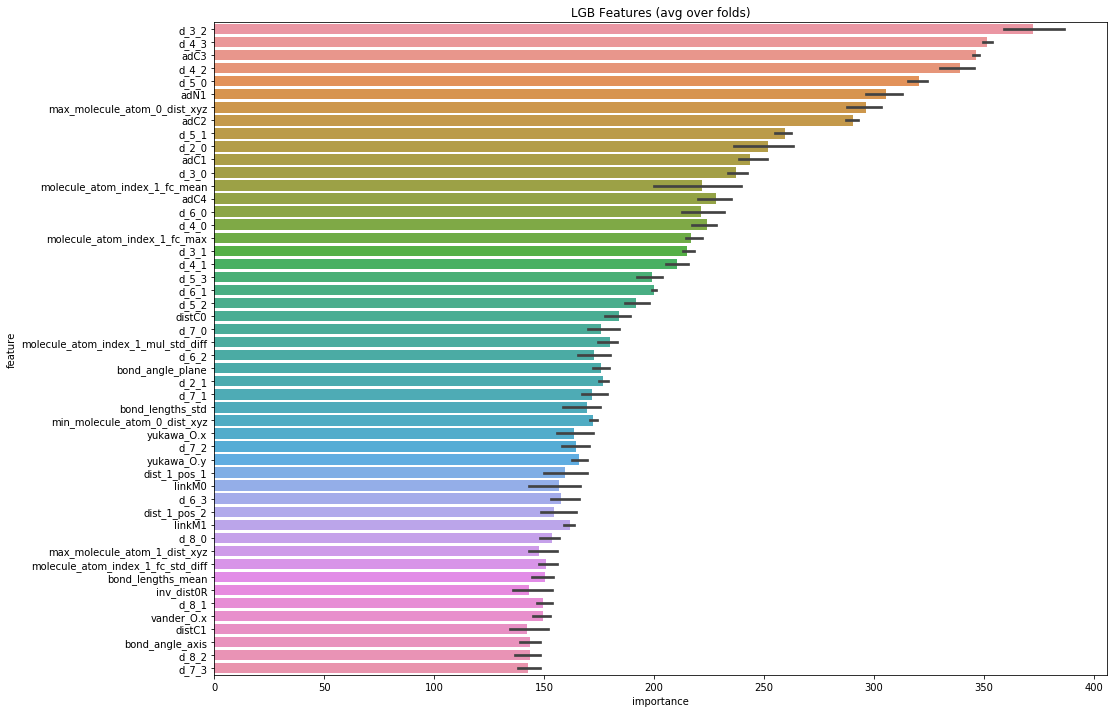

Wall time: 25min 50s


In [26]:
%%time
CV_score = 0
###Iters###    [1JHC, 1JHN, 2JHC, 2JHH, 2JHN, 3JHC, 3JHH, 3JHN]
# n_estimators = [5000, 2500, 3000, 2500, 2500, 3000, 2500, 2500]
n_estimators = 500
n_fold = 3
# metric = partial(group_mean_log_mae, types=X['type'])
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'min_data_in_leaf' : 100,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }

feature_importance = {}
for t in train['type'].unique()[:1]:
    type_ = lbl.inverse_transform([t])[0]
    print(f'\nTraining of type {t}: {type_}.')
    index_type = (train['type'] == t)
    index_type_test = (test['type'] == t)
    
    X_t = train.loc[index_type].copy()
    X_test_t = test.loc[index_type_test].copy()
    y_t = y[index_type]
    
    print(f'Generating features...')
    start_time = time.time()
    
    ## Generating features from the public kernels, just by type
    ## no memory reduction is needed
    X_t = allfeatures(X_t, 1, type_)
    X_test_t = allfeatures(X_test_t, 0, type_)
    G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
    X_t = X_t[G_cols]
    X_test_t = X_test_t[G_cols]
    X_t = encode_categoric_single(X_t)
    X_test_t = encode_categoric_single(X_test_t)
    gc.collect()
    
    #lbl encoding
#     X_test_t = del_cols(X_test_t,['id','molecule_name'])
#     X_t = del_cols(X_t,['id','molecule_name'])

#     X_t = encode_categoric_single(X_t)
#     X_test_t = encode_categoric_single(X_test_t)

    print(f'Done in {(time.time() - start_time):.2f} seconds for {X_t.shape[1]} features.')
    ## feature generation done
    
    
#     result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
#                                               y=y_t, params=params, 
#                                               folds=folds, 
#                                               model_type='lgb', 
#                                               eval_metric='mae', 
#                                               plot_feature_importance=False,
#                                               verbose=2000, early_stopping_rounds=200, 
#                                               n_estimators=n_estimators[t])
    
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=folds,
                                              model_type='lgb',
                                              eval_metric='group_mae',
                                              plot_feature_importance=True,
                                              verbose=500, early_stopping_rounds=200, 
                                              n_estimators=n_estimators)
    del X_t, X_test_t
    plt.show();
    
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
    ## manually computing the cv score
    CV_score += np.log(np.array(result_dict_lgb['scores']).mean())/8 # total 8 types
    feature_importance[t] = result_dict_lgb['feature_importance']
    X_short_test.to_csv('NoMemFlow_model_X.csv')
    del result_dict_lgb

In [ ]:
bad_advers_columns = {}

for t in feature_importance.keys():
    cols = feature_importance[t][["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)
    bad_advers_columns[t] = cols

# Features_importances = bad_advers_columns[0].copy() 
Features_importances = pd.read_csv('Features_importances1.csv').set_index('feature')

for t in feature_importance.keys():
#     sil = pd.merge(sil, bad_advers_columns[t], left_index = True, 
#              right_index= True).rename({'importance_x':f'Feature importance {t}','importance_y':f'Feature importance {t}'}, axis = 1)
    Features_importances[f'Feature importance {t}'] = bad_advers_columns[t]['importance']

   
#     print (t, cols)


In [19]:
t = 0                                                                           ### Set type
type_ = lbl.inverse_transform([t])[0]
print(f'\nTraining of type {t}: {type_}.')
index_type = (train['type'] == t)
index_type_test = (test['type'] == t)

X_t = train.loc[index_type].copy()
X_test_t = test.loc[index_type_test].copy()
y_t = y[index_type]

print(f'Generating features...')
start_time = time.time()

## Generating features from the public kernels, just by type
## no memory reduction is needed
X_t = allfeatures(X_t, 1, type_)
X_test_t = allfeatures(X_test_t, 0, type_)
G_cols = np.append(Features_importances[Features_importances[f'Feature importance {t}'] > 100].index.values , 'type')
X_t = X_t[G_cols]
X_test_t = X_test_t[G_cols]
X_t = encode_categoric_single(X_t)
X_test_t = encode_categoric_single(X_test_t)
gc.collect()


Training of type 0: 1JHC.
Generating features...
Mem. usage decreased to 559.51 Mb (71.8% reduction)
Mem. usage decreased to 308.53 Mb (71.0% reduction)


0

Training for fold type ShuffleSplit(n_splits=5, random_state=11, test_size='default',
       train_size=None)
Fold 1 started at Mon Aug 19 13:57:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.551997	valid_1's l1: 0.761557
[1000]	training's l1: 0.389478	valid_1's l1: 0.701795
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.389478	valid_1's l1: 0.701795
Fold 2 started at Mon Aug 19 14:07:14 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.552186	valid_1's l1: 0.764035
[1000]	training's l1: 0.388535	valid_1's l1: 0.703063
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.388535	valid_1's l1: 0.703063
Fold 3 started at Mon Aug 19 14:16:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.55234	valid_1's l1: 0.763367
[1000]	training's l1: 0.389015	valid_1's l1: 0.701725
Did not meet early stopping. Best iteration is:


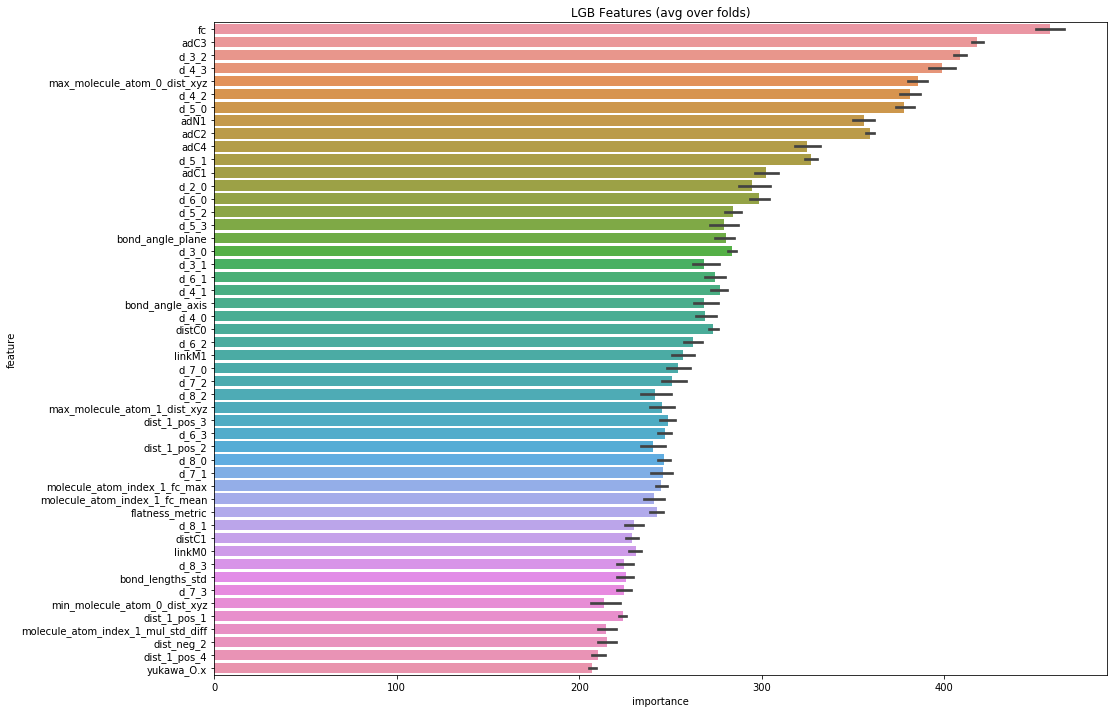

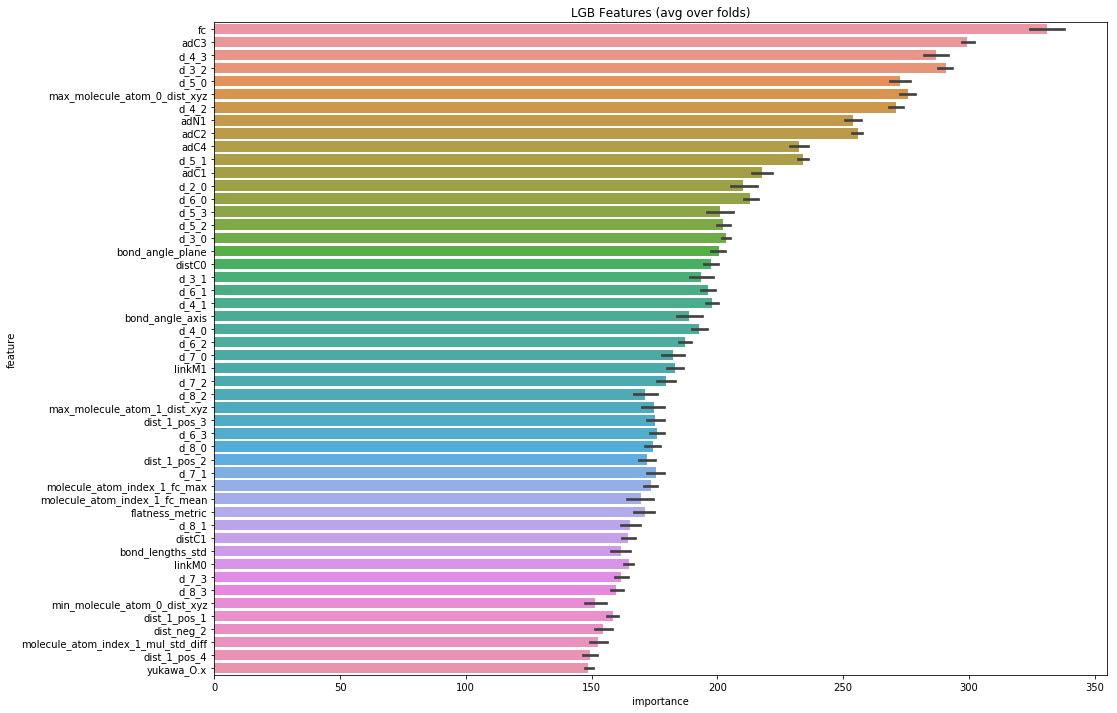

In [37]:
from sklearn.model_selection import LeaveOneOut as loo
params = {'num_leaves': 164, 
 'min_child_samples': 6, 
 'scale_pos_weight': 499.9040515324145, 
 'min_data_in_leaf': 100,
 'objective': 'regression',
 'max_depth': 12, 
 'learning_rate': 0.2, 
 'boosting_type': 'gbdt',
 'subsample_freq': 1, 
 'subsample': 0.8854133465427964,
 'bagging_seed': 11,
 'metric': 'mae',
 'verbosity': -1, 
 'reg_alpha': 0.1, 
 'reg_lambda': 0.3, 
 'colsample_bytree': 0.9094871090944039}

n_estimators = 1000
n_fold = 3

# kfold_shufle = KFold(n_splits=n_fold, shuffle=True, random_state=11)
# kfold_no_shufle = KFold(n_splits=n_fold, shuffle=False, random_state=11)
# gfold = GroupKFold(n_splits=n_fold)
# shufle_split_1 = ShuffleSplit(n_splits=3, random_state=11) ##-0.5549
shufle_split_2 = ShuffleSplit(n_splits=5, random_state=11) ##-0.5581
shufle_split_3 = ShuffleSplit(n_splits=7, random_state=11) ## -0.5643
for fold in [shufle_split_2, shufle_split_3]: 
    
    print('Training for fold type {}'.format(str(fold)))
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=fold,
                                              model_type='lgb',
                                              eval_metric='group_mae',
                                              plot_feature_importance=True,
                                              verbose=500, early_stopping_rounds=200, 
                                              n_estimators=n_estimators)

In [34]:
GroupKFold.split?


In [ ]:
GroupKFold().split

In [ ]:
GroupKFold().split

In [26]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GroupKFold
# ShuffleSplit?
GroupKFold?

In [33]:
lgb.LGBMRegressor?

In [ ]:
Features_importances.to_csv('Features_importances1.csv')

In [ ]:
for a in range(7):
    Features_importances

In [ ]:
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('NoMemFlow_Model_X.csv', index = False)

In [ ]:
sub